In [203]:
import numpy as np
import pandas
import re
import math
import random
import nltk
import time
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
from time import time

# SVM

## Binary Classification

In [204]:
from cvxopt import matrix
from cvxopt import solvers

### Loading the SVM data 

In [205]:
d = 9
svm_train_data = pandas.read_csv('./data/fashion_mnist/train.csv').values
svm_test_data = pandas.read_csv('./data/fashion_mnist/test.csv').values
svm_validation_data = pandas.read_csv('./data/fashion_mnist/val.csv').values

### Linear

In [206]:
# Required data
svm_train_data_r = svm_train_data[(svm_train_data[:, -1] == (d + 1) % 10) + (svm_train_data[:, -1] == d), :]
svm_test_data_r = svm_test_data[(svm_test_data[:, -1] == (d + 1) % 10) + (svm_test_data[:, -1] == d), :]
svm_validation_data_r = svm_validation_data[(svm_validation_data[:, -1] == (d + 1) % 10) + (svm_validation_data[:, -1] == d), :]
svm_train_data_r.shape

(4500, 785)

In [207]:
# Reading y's
y_train = svm_train_data_r[:, -1]
y_train[y_train == d] = -1
y_train[y_train == (d + 1) % 10] = 1

y_test = svm_test_data_r[:, -1]
y_test[y_test == d] = -1
y_test[y_test == (d + 1) % 10] = 1

y_val = svm_validation_data_r[:, -1]
y_val[y_val == d] = -1
y_val[y_val == (d + 1) % 10] = 1

In [208]:
# Reading x's and normalising
x_train = (np.delete(svm_train_data_r, -1, axis = 1) / 255).T
x_test = (np.delete(svm_test_data_r, -1, axis = 1) / 255).T
x_val = (np.delete(svm_validation_data_r, -1, axis = 1) / 255).T

# Noise
C = 1.0

In [209]:
# Calculating P matrix
def get_p_matrix(x, y, isLinear = True, k_matrix = np.array([])):
    y_diag = y.reshape((-1, 1))
    if isLinear:
        p_matrix = np.matmul(x.T, x)
    else:
        p_matrix = k_matrix
    p_matrix = y_diag * p_matrix
    y_diag = y_diag.T
    p_matrix = p_matrix * y_diag
    p_matrix = matrix(p_matrix)
    return p_matrix

In [210]:
# Calculating q matrix
def get_q_matrix(y):
    q_matrix = -matrix(np.ones_like(y))
    return q_matrix

In [211]:
# Calculating A and b matrices
def get_A_matrix(y):
    A_matrix = matrix(y.reshape(1, -1)) 
    return A_matrix
def get_B_matrix():
    b_matrix = matrix([0.0])
    return b_matrix

In [212]:
# Calculating G and h matrices
def get_G_matrix(y):
    G_1 = np.identity(np.shape(y)[0])
    G_2 = -G_1
    G_matrix = matrix(np.vstack((G_1, G_2)))
    return G_matrix
def get_h_matrix(y):
    h_1 = C * np.ones_like(y)
    h_2 = 0 * h_1
    h_matrix = matrix(np.append(h_1, h_2))
    return h_matrix

In [230]:
# Solving the problem
def get_alpha(p, q, G, h, A, b):
    sol = solvers.qp(p, q, G, h, A, b)
    alpha = np.array(sol['x'])
    return alpha

t0 = time()
p_matrix = get_p_matrix(x_train, y_train)
q_matrix = get_q_matrix(y_train)
A_matrix = get_A_matrix(y_train)
b_matrix = get_B_matrix()
G_matrix = get_G_matrix(y_train)
h_matrix = get_h_matrix(y_train)
alpha = get_alpha(p_matrix, q_matrix, G_matrix, h_matrix, A_matrix, b_matrix)

# Calculating W
y_diag = (y_train.reshape((-1, 1))).T
w = (x_train * y_diag) @ alpha

# Calculating b
x_temp_0 = svm_train_data[(svm_train_data[:, -1] == d), :]
x_temp_0 = (np.delete(x_temp_0, -1, axis = 1) / 255).T
x_temp_1 = svm_train_data[(svm_train_data[:, -1] == (d + 1) % 10), :]
x_temp_1 = (np.delete(x_temp_1, -1, axis = 1) / 255).T
x_temp_0.shape
maximum = np.max(w.T @ x_temp_0)
minimum = np.min(w.T @ x_temp_1)
b = - (maximum + minimum) / 2.0

print("Training time:", time() - t0)
print(w, b)

     pcost       dcost       gap    pres   dres
 0: -1.3874e+02 -7.3498e+03  4e+04  2e+00  1e-12
 1: -7.8159e+01 -3.6059e+03  7e+03  3e-01  1e-12
 2: -2.3151e+01 -8.1591e+02  1e+03  6e-02  6e-13
 3: -8.2817e+00 -3.2692e+02  5e+02  2e-02  3e-13
 4: -1.9531e+00 -5.9043e+01  9e+01  3e-03  7e-14
 5: -6.9181e-01 -1.3465e+01  2e+01  7e-04  3e-14
 6: -3.3850e-01 -2.8374e+00  3e+00  1e-04  2e-14
 7: -3.3182e-01 -1.0866e+00  8e-01  2e-16  2e-14
 8: -4.8517e-01 -8.0175e-01  3e-01  2e-16  2e-14
 9: -5.4774e-01 -6.8892e-01  1e-01  2e-16  2e-14
10: -5.8820e-01 -6.2264e-01  3e-02  2e-16  2e-14
11: -6.0131e-01 -6.0673e-01  5e-03  2e-16  2e-14
12: -6.0378e-01 -6.0391e-01  1e-04  2e-16  2e-14
13: -6.0384e-01 -6.0384e-01  2e-06  2e-16  2e-14
14: -6.0384e-01 -6.0384e-01  2e-08  2e-16  2e-14
Optimal solution found.
[[ 0.00000000e+00]
 [ 8.12796986e-14]
 [ 2.36715512e-03]
 [ 1.56027089e-02]
 [ 8.05393483e-03]
 [ 5.45037221e-03]
 [ 4.73988693e-04]
 [ 7.65034582e-03]
 [ 1.17443457e-03]
 [ 1.41829683e-02]
 [ 

In [216]:
# Calculating # of Support vectors
print("Number of support vectors are:", np.where(alpha > 1e-6)[0].shape[0])

Number of support vectors are: 58


In [214]:
# Predicting on test data
pred_test = (w.T @ x_test) + b
pred_test[pred_test >= 0] = 1
pred_test[pred_test < 0] = -1
count = 0
total = pred_test.shape[1]
for (i, p) in enumerate(pred_test[0, :]):
    if p == y_test[i]:
        count += 1
print("Accuracy is {}".format(count * 100 / total))

Accuracy is 100.0


In [215]:
# Predicting on validation data
pred_val = (w.T @ x_val) + b
pred_val[pred_val >= 0] = 1
pred_val[pred_val < 0] = -1
count = 0
total = pred_val.shape[1]
for (i, p) in enumerate(pred_val[0, :]):
    if p == y_val[i]:
        count += 1
print("Accuracy is {}".format(count * 100 / total))

Accuracy is 99.8


### Gaussian

In [217]:
from scipy.spatial.distance import pdist, cdist, squareform

In [218]:
# Calculating the Gaussian Kernel
def get_k_matrix(x0, x1):
    return np.exp(-gamma * cdist(x0.T, x1.T) ** 2)

In [219]:
# Calculating Gaussian
gamma = 0.05
# pairwise_dists = squareform(pdist(x_train.T, 'euclidean'))

In [220]:
# Changing P_matrix

In [234]:
# Solving the problem
t0 = time()
k_matrix = get_k_matrix(x_train, x_train)
p_matrix = get_p_matrix(x_train, y_train, False, k_matrix)
q_matrix = get_q_matrix(y_train)
A_matrix = get_A_matrix(y_train)
b_matrix = get_B_matrix()
G_matrix = get_G_matrix(y_train)
h_matrix = get_h_matrix(y_train)
alpha = get_alpha(p_matrix, q_matrix, G_matrix, h_matrix, A_matrix, b_matrix)

# Calculating B
def get_gauss_b(x0, x1, x, y, a):
    x_list_0 = np.sum(y[:, None] * a * get_k_matrix(x, x0), axis = 0)
    x_list_1 = np.sum(y[:, None] * a * get_k_matrix(x, x1), axis = 0)
    b = -(np.max(x_list_0) + np.min(x_list_1)) / 2.0
    return b

# Extracting the xi's
x_temp_0 = svm_train_data[(svm_train_data[:, -1] == d), :]
x_temp_0 = (np.delete(x_temp_0, -1, axis = 1) / 255).T
x_temp_1 = svm_train_data[(svm_train_data[:, -1] == (d + 1) % 10), :]
x_temp_1 = (np.delete(x_temp_1, -1, axis = 1) / 255).T

b = get_gauss_b(x_temp_0, x_temp_1, x_train, y_train, alpha)

print(f"Training time (test): {round(time()-t0, 3)}s")
print(alpha, b)

     pcost       dcost       gap    pres   dres
 0: -1.3464e+02 -6.8388e+03  3e+04  2e+00  2e-15
 1: -7.6690e+01 -3.2910e+03  5e+03  2e-01  1e-15
 2: -5.4390e+01 -6.8811e+02  8e+02  3e-02  4e-15
 3: -8.6653e+01 -2.4599e+02  2e+02  5e-03  2e-15
 4: -1.0255e+02 -1.5246e+02  5e+01  1e-03  2e-15
 5: -1.0963e+02 -1.2739e+02  2e+01  3e-04  1e-15
 6: -1.1318e+02 -1.1820e+02  5e+00  4e-05  1e-15
 7: -1.1445e+02 -1.1556e+02  1e+00  4e-06  1e-15
 8: -1.1479e+02 -1.1496e+02  2e-01  5e-07  1e-15
 9: -1.1485e+02 -1.1486e+02  5e-03  9e-09  2e-15
10: -1.1485e+02 -1.1485e+02  1e-04  2e-10  2e-15
Optimal solution found.
Training time (test): 79.045s
[[1.79782522e-08]
 [1.05001976e-08]
 [2.06355675e-08]
 ...
 [2.55784735e-01]
 [1.48695055e-08]
 [6.10306771e-08]] 0.03104794581962378


In [254]:
# Calculating alpha
print("Number of support vectors are: ", np.where(alpha > 1e-6)[0].shape[0])

Number of support vectors are:  878


In [223]:
def get_gauss_prediction(a, b, x, y, x_t):
    k_matrix_test = y[:, None] * a * get_k_matrix(x, x_t)
    return np.sum(k_matrix_test, axis = 0) + b

In [224]:
# Predicting on test data
t0 = time()
pred_test = get_gauss_prediction(alpha, b, x_train, y_train, x_test)
pred_test[pred_test >= 0] = 1
pred_test[pred_test < 0] = -1
count = 0
total = pred_test.shape[0]
for (i, p) in enumerate(pred_test):
    if p == y_test[i]:
        count += 1
print("Test Accuracy is {}".format(count * 100 / total))
print(f"Prediction time (test): {round(time()-t0, 3)}s")

Test Accuracy is 100.0
Prediction time (test): 3.428s


In [225]:
# Predicting on validation data
t0 = time()
pred_val = get_gauss_prediction(alpha, b, x_train, y_train, x_val)
pred_val[pred_val >= 0] = 1
pred_val[pred_val < 0] = -1
count = 0
total = pred_val.shape[0]
for (i, p) in enumerate(pred_val):
    if p == y_val[i]:
        count += 1
print("Validation Accuracy is {}".format(count * 100 / total))
print(f"Prediction time (Validation): {round(time()-t0, 3)}s")

Validation Accuracy is 100.0
Prediction time (Validation): 1.535s


### Sklearn

In [226]:
from sklearn.svm import SVC
from sklearn import metrics

In [232]:
# Linear 
# Create a svm Classifier
clf = SVC(kernel='linear', C=C) # Linear Kernel

t0 = time()
# Train the model using the training sets
clf.fit(x_train.T, y_train)
print("Training time:", time() - t0)

# Predict the response for test dataset
y_pred = clf.predict(x_test.T)

# Predicting accuracy
print("Linear Accuracy(test):", metrics.accuracy_score(y_test, y_pred))

# Predict the response for validation dataset
y_pred = clf.predict(x_val.T)

# Printing parameter values
print(clf.coef_[0])
print(clf.intercept_[0])

# Predicting accuracy
print("Linear Accuracy(validation):", metrics.accuracy_score(y_val, y_pred))
print("Number of support vectors:", np.sum(clf.n_support_))

Training time: 0.26759910583496094
Linear Accuracy(test): 1.0
[ 0.00000000e+00  0.00000000e+00  2.38047578e-03  1.56006981e-02
  8.05775404e-03  5.45754430e-03  4.73981618e-04  7.63388505e-03
  1.16474941e-03  1.41774245e-02  2.93088934e-02  3.88332735e-02
  5.00566242e-03 -8.26934002e-03  1.86300437e-03 -1.06883307e-02
 -4.17045169e-02 -4.33714169e-02 -5.99775211e-02 -4.57863991e-02
 -3.74955187e-02 -3.31739570e-02 -2.53721694e-02  4.99279344e-02
  4.10967777e-03 -8.05641015e-04  1.77508277e-04  0.00000000e+00
  3.15733928e-04  0.00000000e+00  4.98999208e-03  3.71858661e-02
  2.09438178e-02  8.13984164e-03  7.88207738e-03  7.48866380e-03
  5.47137439e-03  1.93531726e-02 -6.72696985e-03 -5.29110960e-03
 -1.07209489e-02  1.46272834e-02  7.32927404e-02  6.18820959e-02
 -2.02293915e-02  2.48077663e-03  7.02639247e-03 -2.26658858e-02
 -2.84213298e-02 -2.84954934e-02 -2.92596912e-02  8.02452844e-02
  3.40433255e-02  9.62028943e-03  2.46114764e-03  4.78024861e-03
  0.00000000e+00  2.10489286

In [255]:
# Gaussian
# Create a svm Classifier
clf = SVC(kernel='rbf', gamma=gamma, C=C) # Gaussian Kernel

t0 = time()
# Train the model using the training sets
clf.fit(x_train.T, y_train)
print("Training time:", time() - t0)

# Predict the response for test dataset
y_pred = clf.predict(x_test.T)

# Predicting accuracy
print("Gaussian Accuracy(test):", metrics.accuracy_score(y_test, y_pred))

# Predict the response for validation dataset
y_pred = clf.predict(x_val.T)

# Printing parameter values
print(clf.dual_coef_[0])
print(clf.intercept_[0])

# Predicting accuracy
print("Gaussian Accuracy(validation):", metrics.accuracy_score(y_val, y_pred))
print("Number of support vectors:", np.sum(clf.n_support_))

Training time: 3.427978992462158
Gaussian Accuracy(test): 0.997997997997998
[-1.72496559e-01 -1.75971058e-02 -3.87856185e-01 -3.79531915e-01
 -2.82074636e-01 -4.93384331e-01 -2.25930934e-01 -2.66561184e-01
 -7.82841990e-01 -2.69319961e-01 -2.85213829e-02 -3.52676394e-01
 -5.21484659e-02 -1.44595571e-01 -2.10995303e-01 -2.21321658e-01
 -6.50962797e-02 -5.13154980e-01 -3.78511547e-02 -1.71374592e-01
 -1.81587423e-02 -1.41200209e-01 -5.79410597e-02 -7.03018725e-02
 -1.14784093e-01 -9.02009192e-01 -4.45678714e-01 -3.29517311e-01
 -7.33216641e-02 -4.95566770e-01 -1.89987291e-01 -5.65319237e-01
 -8.08102951e-01 -2.34943313e-01 -9.03602567e-02 -4.64460155e-02
 -1.94466847e-01 -8.01175925e-01 -1.66263912e-01 -4.03736486e-01
 -3.50619001e-01 -3.54702827e-01 -5.52053642e-02 -2.25584856e-01
 -9.15066979e-03 -3.96699250e-01 -1.53409335e-01 -7.54928183e-01
 -1.09528483e-01 -6.20981037e-01 -2.56126356e-02 -2.28554995e-02
 -1.49514432e-01 -7.70219076e-02 -3.81119328e-01 -4.53977051e-01
 -2.15570485e-

## Multiclass Classification

### Gaussian

In [137]:
# Reading training data
X_train = {}
Y_train = {}
y_train_m = svm_train_data[:, -1]
x_train_m = (np.delete(svm_train_data, -1, axis = 1) / 255).T
for i in range(10):
    svm_train_data_t = svm_train_data[(svm_train_data[:, -1] == i), :]
    Y_train[i] = svm_train_data_t[:, -1]
    X_train[i] = (np.delete(svm_train_data_t, -1, axis = 1) / 255).T

# Reading test data
X_test = {}
Y_test = {}
temp = np.copy(svm_test_data)
x_test_m = (np.delete(temp, -1, axis = 1) / 255).T
y_test_m = temp[:, -1]
for i in range(10):
    svm_test_data_t = svm_test_data[(svm_test_data[:, -1] == i), :]
    Y_test[i] = svm_test_data_t[:, -1]
    X_test[i] = (np.delete(svm_test_data_t, -1, axis = 1) / 255).T

# Reading validation data
X_val = {}
Y_val = {}
temp = np.copy(svm_validation_data)
x_validation = (np.delete(temp, -1, axis = 1) / 255).T
y_validation = temp[:, -1]
for i in range(10):
    svm_val_data_t = svm_validation_data[(svm_validation_data[:, -1] == i), :]
    Y_val[i] = svm_val_data_t[:, -1]
    X_val[i] = (np.delete(svm_val_data_t, -1, axis = 1) / 255).T

In [138]:
# Calculating alpha's matrices
def get_alpha_s(X, Y):
    alpha_d = {}
    for i in range(10):
        for j in range(i + 1, 10):
            # Getting alpha for i vs j classification
            x = np.vstack((X[i].T, X[j].T)).T
            y = np.append(Y[i], Y[j])
            y[y == i] = -1
            y[y == j % 10] = 1
            
            # Calculating the relevant matrices
            k = get_k_matrix(x, x)
            p = get_p_matrix(x, y, isLinear=False, k_matrix = k)
            q = get_q_matrix(y)
            G = get_G_matrix(y)
            h = get_h_matrix(y)
            A = get_A_matrix(y)
            B_matrix = get_B_matrix()

            alpha_d[i, j] = get_alpha(p, q, G, h, A, B_matrix)
    return alpha_d

In [139]:
def get_b_dict(X, Y, alpha_dict):
    b_dict = {}
    for i in range(10):
        for j in range(i + 1, 10):
            
            print(i, j)
            
            # Getting b for i vs j classification
            x = np.vstack((X[i].T, X[j].T)).T
            y = np.append(Y[i], Y[j])
            y[y == i] = -1
            y[y == j % 10] = 1

            # Calculating the relevant matrices
            b_dict[i, j] = get_gauss_b(X[i], X[j] , x, y, alpha_dict[i, j])
            
    return b_dict

In [140]:
t0 = time()
def train(X, Y):
    alpha_dict = get_alpha_s(X, Y)
    return get_b_dict(X, Y, alpha_dict), alpha_dict

b_dict, alpha_dict = train(X_train, Y_train)
print(f"Training time (test): {round(time()-t0, 3)}s")

     pcost       dcost       gap    pres   dres
 0: -1.6492e+02 -6.6070e+03  3e+04  2e+00  5e-15
 1: -1.1407e+02 -3.0686e+03  5e+03  2e-01  4e-15
 2: -1.0459e+02 -7.6952e+02  9e+02  3e-02  5e-15
 3: -1.2684e+02 -3.0203e+02  2e+02  6e-03  4e-15
 4: -1.4133e+02 -2.0101e+02  6e+01  1e-03  3e-15
 5: -1.4945e+02 -1.6809e+02  2e+01  2e-04  3e-15
 6: -1.5144e+02 -1.6280e+02  1e+01  3e-05  3e-15
 7: -1.5364e+02 -1.5728e+02  4e+00  7e-06  3e-15
 8: -1.5443e+02 -1.5550e+02  1e+00  6e-14  3e-15
 9: -1.5478e+02 -1.5492e+02  1e-01  7e-14  3e-15
10: -1.5483e+02 -1.5484e+02  4e-03  1e-14  3e-15
11: -1.5483e+02 -1.5483e+02  6e-05  7e-14  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.7366e+02 -8.4330e+03  4e+04  2e+00  6e-15
 1: -2.8341e+02 -4.5691e+03  7e+03  2e-01  5e-15
 2: -2.6181e+02 -1.1549e+03  1e+03  3e-02  6e-15
 3: -3.1375e+02 -5.8168e+02  3e+02  6e-03  5e-15
 4: -3.4227e+02 -4.1865e+02  8e+01  1e-03  5e-15
 5: -3.5409e+02 -3.7849e+02  2e+01  2e-04  5e-1

12: -8.2297e+01 -8.2297e+01  4e-05  2e-13  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6321e+02 -6.5609e+03  3e+04  2e+00  5e-15
 1: -1.1075e+02 -3.0589e+03  5e+03  2e-01  3e-15
 2: -1.0167e+02 -7.6887e+02  9e+02  3e-02  4e-15
 3: -1.2535e+02 -3.1952e+02  2e+02  7e-03  3e-15
 4: -1.4028e+02 -2.0638e+02  7e+01  2e-03  3e-15
 5: -1.4794e+02 -1.7118e+02  2e+01  2e-04  3e-15
 6: -1.5107e+02 -1.6136e+02  1e+01  1e-05  3e-15
 7: -1.5295e+02 -1.5632e+02  3e+00  3e-06  2e-15
 8: -1.5376e+02 -1.5442e+02  7e-01  1e-13  3e-15
 9: -1.5397e+02 -1.5405e+02  8e-02  2e-13  3e-15
10: -1.5400e+02 -1.5400e+02  2e-03  2e-13  3e-15
11: -1.5400e+02 -1.5400e+02  6e-05  4e-14  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.5955e+01 -6.5221e+03  3e+04  2e+00  5e-15
 1: -3.1834e+01 -2.9574e+03  5e+03  2e-01  2e-15
 2: -1.0088e+01 -5.1383e+02  7e+02  2e-02  5e-15
 3: -2.7978e+01 -1.2024e+02  1e+02  3e-03  3e-15
 4: -3.8190e+01 -7.0454

10: -1.2186e+02 -1.2187e+02  1e-02  6e-14  2e-15
11: -1.2186e+02 -1.2186e+02  1e-04  1e-13  2e-15
12: -1.2186e+02 -1.2186e+02  3e-06  2e-13  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.1433e+02 -9.6131e+03  5e+04  3e+00  8e-15
 1: -3.9419e+02 -5.7409e+03  8e+03  3e-01  8e-15
 2: -3.6455e+02 -1.3710e+03  1e+03  2e-02  9e-15
 3: -4.4119e+02 -7.5464e+02  3e+02  5e-03  8e-15
 4: -4.7842e+02 -5.8509e+02  1e+02  5e-04  8e-15
 5: -4.9392e+02 -5.2894e+02  4e+01  1e-04  8e-15
 6: -4.9931e+02 -5.1319e+02  1e+01  3e-05  8e-15
 7: -5.0143e+02 -5.0716e+02  6e+00  2e-13  9e-15
 8: -5.0278e+02 -5.0408e+02  1e+00  8e-13  8e-15
 9: -5.0315e+02 -5.0328e+02  1e-01  8e-13  9e-15
10: -5.0319e+02 -5.0320e+02  4e-03  6e-13  9e-15
11: -5.0319e+02 -5.0319e+02  7e-05  7e-13  9e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.2836e+01 -7.1347e+03  3e+04  2e+00  5e-15
 1: -4.5561e+01 -3.4670e+03  6e+03  2e-01  2e-15
 2: -6.5966e+00 -7.3664

 9: -2.6674e+02 -2.6679e+02  5e-02  2e-13  3e-15
10: -2.6676e+02 -2.6676e+02  1e-03  3e-13  3e-15
11: -2.6676e+02 -2.6676e+02  1e-05  4e-14  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1028e+02 -7.5103e+03  4e+04  2e+00  5e-15
 1: -5.6897e+01 -3.8143e+03  7e+03  3e-01  3e-15
 2: -1.3830e+01 -9.2363e+02  1e+03  4e-02  7e-15
 3: -3.9528e+01 -1.9616e+02  2e+02  4e-03  4e-15
 4: -5.5680e+01 -1.2195e+02  7e+01  2e-03  2e-15
 5: -6.4887e+01 -8.8241e+01  2e+01  1e-04  2e-15
 6: -6.9418e+01 -7.6829e+01  7e+00  2e-05  2e-15
 7: -7.1201e+01 -7.3118e+01  2e+00  2e-06  2e-15
 8: -7.1797e+01 -7.2062e+01  3e-01  1e-07  2e-15
 9: -7.1900e+01 -7.1908e+01  8e-03  2e-09  2e-15
10: -7.1903e+01 -7.1903e+01  1e-04  3e-11  2e-15
11: -7.1903e+01 -7.1903e+01  2e-06  3e-13  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.3801e+02 -8.0319e+03  4e+04  2e+00  5e-15
 1: -2.4315e+02 -4.4272e+03  7e+03  2e-01  3e-15
 2: -2.2086e+02 -9.6970

In [141]:
# Saving learnt dictionaries
np.save('alpha.npy', alpha_dict)
np.save('b_dict.npy', b_dict)

In [142]:
def sigmoid(x):
    e = 1 + np.exp(-x)
    return 1 / e

In [143]:
# Prediction on validation data
def get_prediction_dict(alpha_d, b_d, X, Y, x_t):
    
    m = x_t.shape[-1]
    score_array = np.zeros((10, m))
    votes = np.zeros((10, m))
    index = [i for i in range(10)]
    index = np.repeat(index, m).reshape((10, m))
    prediction = np.array([])
    
    # Forming the score array    
    for i in range(10):
        for j in range(i + 1, 10):
            print(i, j)
            x = np.vstack((X[i].T, X[j].T)).T
            y = np.append(Y[i], Y[j])
            y[y == i] = -1
            y[y == j % 10] = 1
            score = get_gauss_prediction(alpha_d[i, j], b_d[i, j], x, y, x_t)
            
            # Tiebreaker      
            score_i = np.array(score)
            score_i[score_i >= 0] = 0
            score_i = np.abs(score_i)
            
            # Tiebreaker      
            score_j = np.array(score)
            score_j[score_j < 0] = 0
            score_j = np.abs(score_j)

            pred_i = np.array(score)
            pred_i[pred_i >= 0] = 0
            pred_i[pred_i < 0] = 1
            
            pred_j = np.array(score)
            pred_j[pred_j >= 0] = 1
            pred_j[pred_j < 0] = 0
            
            votes[i] += pred_i    
            votes[j] += pred_j
            score_array[i] += score_i
            score_array[j] += score_j
            
    all_arrays = np.dstack((votes.T, score_array.T, index.T))
    for i in range(m):
        prediction = np.append(prediction, max(tuple(map(tuple, all_arrays[i])))[2])
    return prediction

In [144]:
t0 = time()
prediction_test = get_prediction_dict(alpha_dict, b_dict, X_train, Y_train, x_test_m)
print(f"Prediction time (test): {round(time()-t0, 3)}s")

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
Prediction time (test): 798.657s


In [145]:
def get_accuracy(y_pred, y_actual):
    total = y_actual.shape[0]
    count = 0
    for (i, p) in enumerate(y_pred):
        if p == y_actual[i]:
            count += 1
    return count * 100 / total

print("Test accuracy is(test):", get_accuracy(prediction_test, y_test_m))

Test accuracy is(test): 85.07701540308062


In [147]:
t0 = time()
prediction_val = get_prediction_dict(alpha_dict, b_dict, X_train, Y_train, x_validation)
print(f"Prediction time (validation): {round(time()-t0, 3)}s")

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
Prediction time (validation): 370.653s


In [148]:
print("Test accuracy is(validation):", get_accuracy(prediction_val, y_validation))

Test accuracy is(validation): 84.9139655862345


### Sklearn

In [236]:
from sklearn.metrics import confusion_matrix 
from sklearn import multiclass

In [237]:
svm_model_gaussian = SVC(kernel='rbf', gamma=gamma, C=C, decision_function_shape='ovo')

t0 = time()
svm_model_gaussian.fit(x_train_m.T, y_train_m)
print("Training time", time() - t0)

Training time 185.60233902931213


In [238]:
t0 = time()
svm_predictions_test = svm_model_gaussian.predict(x_test_m.T) 
print("Prediction time(test)", time() - t0)

# Accuracy
print("Gaussian Accuracy(test):", metrics.accuracy_score(y_test_m, svm_predictions_test))

t0 = time()
svm_predictions_validation = svm_model_gaussian.predict(x_validation.T) 
print("Prediction time(validation)", time() - t0)

# Accuracy
print("Gaussian Accuracy(validation):", metrics.accuracy_score(y_validation, svm_predictions_validation))

Prediction time(test) 41.72663331031799
Gaussian Accuracy(test): 0.8807761552310462
Prediction time(validation) 22.35387420654297
Gaussian Accuracy(validation): 0.8791516606642658


### Confusion Matrix

In [240]:
# Test confusion matrices
cm_sklearn_t = confusion_matrix(y_test_m, svm_predictions_test) 
cm_own_implementation_t = confusion_matrix(y_test_m, prediction_test) 

In [245]:
def print_confusion_matrix(c):
    for c1 in c:
        for c2 in c1:
            print(c2, end=' & ')
        print("\\\\")

In [246]:
print_confusion_matrix(cm_sklearn_t)

432 & 0 & 5 & 11 & 3 & 0 & 38 & 0 & 10 & 0 & \\
1 & 482 & 4 & 9 & 0 & 0 & 4 & 0 & 0 & 0 & \\
5 & 0 & 411 & 7 & 37 & 0 & 32 & 0 & 8 & 0 & \\
12 & 0 & 3 & 457 & 9 & 0 & 14 & 0 & 5 & 0 & \\
3 & 1 & 41 & 13 & 399 & 0 & 38 & 0 & 5 & 0 & \\
0 & 0 & 0 & 0 & 0 & 473 & 0 & 16 & 5 & 6 & \\
80 & 0 & 55 & 9 & 34 & 0 & 315 & 0 & 7 & 0 & \\
0 & 0 & 0 & 0 & 0 & 14 & 0 & 471 & 1 & 14 & \\
1 & 0 & 1 & 1 & 2 & 2 & 2 & 2 & 489 & 0 & \\
0 & 0 & 0 & 0 & 0 & 11 & 0 & 14 & 1 & 474 & \\


In [248]:
print_confusion_matrix(cm_own_implementation_t)

403 & 0 & 7 & 7 & 0 & 0 & 65 & 0 & 17 & 0 & \\
0 & 484 & 6 & 2 & 0 & 0 & 6 & 0 & 2 & 0 & \\
0 & 0 & 414 & 3 & 26 & 0 & 44 & 0 & 13 & 0 & \\
17 & 10 & 2 & 410 & 6 & 0 & 39 & 0 & 16 & 0 & \\
0 & 1 & 55 & 12 & 366 & 0 & 51 & 0 & 15 & 0 & \\
1 & 0 & 0 & 0 & 0 & 432 & 0 & 7 & 48 & 12 & \\
52 & 1 & 52 & 5 & 20 & 0 & 351 & 0 & 19 & 0 & \\
0 & 0 & 0 & 0 & 0 & 48 & 0 & 411 & 6 & 35 & \\
1 & 0 & 1 & 0 & 0 & 0 & 3 & 0 & 495 & 0 & \\
0 & 0 & 0 & 0 & 0 & 5 & 0 & 6 & 2 & 487 & \\


In [249]:
# Test confusion matrices
cm_sklearn_v = confusion_matrix(y_validation, svm_predictions_validation) 
cm_own_implementation_v = confusion_matrix(y_validation, prediction_val) 

In [250]:
print_confusion_matrix(cm_sklearn_v)

212 & 0 & 1 & 8 & 0 & 0 & 26 & 0 & 3 & 0 & \\
0 & 237 & 3 & 7 & 0 & 0 & 2 & 0 & 1 & 0 & \\
5 & 0 & 205 & 3 & 18 & 0 & 13 & 0 & 5 & 0 & \\
6 & 0 & 0 & 228 & 6 & 0 & 9 & 0 & 1 & 0 & \\
1 & 1 & 24 & 8 & 200 & 0 & 15 & 0 & 1 & 0 & \\
0 & 0 & 0 & 1 & 0 & 241 & 0 & 2 & 1 & 5 & \\
34 & 0 & 28 & 3 & 19 & 0 & 165 & 0 & 1 & 0 & \\
0 & 0 & 0 & 0 & 0 & 8 & 0 & 230 & 1 & 11 & \\
0 & 0 & 1 & 1 & 1 & 0 & 1 & 2 & 244 & 0 & \\
0 & 0 & 0 & 0 & 0 & 6 & 0 & 8 & 1 & 235 & \\


In [251]:
print_confusion_matrix(cm_own_implementation_v)

201 & 2 & 1 & 4 & 0 & 0 & 38 & 0 & 4 & 0 & \\
0 & 240 & 2 & 2 & 0 & 0 & 3 & 0 & 3 & 0 & \\
2 & 0 & 207 & 1 & 13 & 0 & 14 & 0 & 12 & 0 & \\
11 & 7 & 0 & 197 & 6 & 0 & 20 & 0 & 9 & 0 & \\
0 & 2 & 30 & 5 & 185 & 0 & 19 & 0 & 9 & 0 & \\
0 & 0 & 0 & 1 & 0 & 225 & 0 & 1 & 17 & 6 & \\
19 & 0 & 27 & 1 & 11 & 0 & 184 & 0 & 8 & 0 & \\
0 & 0 & 0 & 0 & 0 & 24 & 0 & 199 & 6 & 21 & \\
0 & 0 & 1 & 0 & 0 & 0 & 2 & 2 & 245 & 0 & \\
0 & 0 & 0 & 0 & 0 & 2 & 0 & 4 & 5 & 239 & \\


## K Fold Validation

In [161]:
from sklearn.model_selection import KFold
c_vals = [1e-5, 1e-3, 1, 5, 10]

In [162]:
def get_k_fold_accuracy(k, x, y, x_test, y_test, c_list):
    kf = KFold(n_splits = k) 
    
    test_accuracy = []
    cv_accuracy = []
    
    for c in c_list:
        accuracy = 0
        svm_model_gaussian = SVC(kernel='rbf', gamma=gamma, C=c, decision_function_shape='ovo')
        
        # Predicting on test data      
        svm_model_gaussian.fit(x, y)
        svm_predictions = svm_model_gaussian.predict(x_test)
        acc = metrics.accuracy_score(y_test, svm_predictions)
        test_accuracy.append(acc)
        
        
        for train_index, test_index in kf.split(x):
            print("hi")
            X_tr, X_te = x[train_index], x[test_index]
            y_tr, y_te = y[train_index], y[test_index]

            # Predicting
            svm_model_gaussian.fit(X_tr, y_tr)
            svm_predictions = svm_model_gaussian.predict(X_te)

            acc = metrics.accuracy_score(y_te, svm_predictions)
            accuracy += acc
            
            # Accuracy  
        print("Gaussian Accuracy(cross - validation) for C = {} : {}".format(c, accuracy / k))
        cv_accuracy.append(accuracy / k)
    return cv_accuracy, test_accuracy

cv_accuracy, test_accuracy = get_k_fold_accuracy(5, x_train_m.T, y_train_m, x_test_m.T, y_test_m, c_vals)

hi
hi
hi
hi
hi
Gaussian Accuracy(cross - validation) for C = 1e-05 : 0.09467084537304585
hi
hi
hi
hi
hi
Gaussian Accuracy(cross - validation) for C = 0.001 : 0.09467084537304585
hi
hi
hi
hi
hi
Gaussian Accuracy(cross - validation) for C = 1 : 0.8783948334197722
hi
hi
hi
hi
hi
Gaussian Accuracy(cross - validation) for C = 5 : 0.8833281766318442
hi
hi
hi
hi
hi
Gaussian Accuracy(cross - validation) for C = 10 : 0.8831059939245758


In [163]:
print(cv_accuracy)
print(test_accuracy)

[0.09467084537304585, 0.09467084537304585, 0.8783948334197722, 0.8833281766318442, 0.8831059939245758]
[0.5339067813562712, 0.5339067813562712, 0.8807761552310462, 0.8827765553110622, 0.882376475295059]


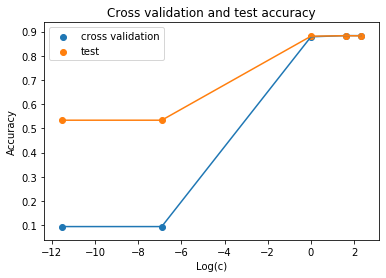

In [252]:
# Plotting the graph
c_vals_log = [np.log(c) for c in c_vals]
plt.scatter(c_vals_log, cv_accuracy, label='cross validation')
plt.scatter(c_vals_log, test_accuracy, label='test')
plt.plot(c_vals_log, cv_accuracy)
plt.plot(c_vals_log, test_accuracy)
plt.title("Cross validation and test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Log(c)")
plt.legend()
plt.show()